## Import modules & functions

In [42]:
import pandas as pd
import numpy as np
from string import punctuation
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, Conv1D
from keras.layers import Dropout
from keras.layers import Activation
from keras import optimizers
from keras import utils
from keras.initializers import Constant
from keras import regularizers


random_state = 47
np.random.seed(random_state)

test = u'This is a smiley face \U0001f603 নিঃশ্বাস ২৫ জানানv  H দিচ্ছে বেঁচে 94 আছি'
print("Collected text: " ,test) # with emoji
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
                                            u"\U0001F600-\U0001F64F"  # emoticons
                                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                            u"!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~০১২৩৪৫৬৭৮৯"
                                                                    "]+", flags = re.UNICODE)
    
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    
    text = regrex_pattern.sub(r'',text)
    text = english_pattern.sub(r'',text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
print("Cleaned text  : ", deEmojify(test))

Collected text:  This is a smiley face 😃 নিঃশ্বাস ২৫ জানানv  H দিচ্ছে বেঁচে 94 আছি
Cleaned text  :  নিঃশ্বাস জানান দিচ্ছে বেঁচে আছি


## Load &  clean Data

In [19]:
filepath = '/content/drive/MyDrive/Work_FTFL_GIGATECH/Sentiment analysis project/Copy of Combined_Dataset.xlsx'
na_values=[np.nan, "", "evenly_voted", "Confusion"]
excel_data = pd.read_excel(filepath, sheet_name='Sheet1', usecols=['Text', 'Polarity '], na_values=na_values)
excel_data = excel_data.dropna()
print(excel_data.info(), "nan values:\n",excel_data.isna().sum())

## lable encoding
le = LabelEncoder()
le.fit(excel_data['Polarity '])
# print(excel_data['Polarity '].iloc[0:10])
excel_data['Polarity '] = le.transform(excel_data['Polarity '])
# print(excel_data['Polarity '].iloc[0:10])

vocab=[]
for index in excel_data.index:
    if excel_data.loc[index, 'Text'] is not np.nan:
        text= deEmojify(excel_data.at[index, 'Text'])
        excel_data.loc[index].at['Text'] = text
        # print(index, type(text), text)
        tokens = text.split()
        vocab.append(tokens)
        # print(index, tokens)
    else:
        print(index+1, "#############-----empty cell-------######")

print(len(vocab))
print(vocab)

save_dir="/content/drive/MyDrive/Work_FTFL_GIGATECH/Sentiment analysis project/cleaned_data.xlsx"
excel_data.to_excel(save_dir, index=False)

excel_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8531 entries, 0 to 8544
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       8531 non-null   object
 1   Polarity   8531 non-null   object
dtypes: object(2)
memory usage: 199.9+ KB
None nan values:
 Text         0
Polarity     0
dtype: int64
8531
[['প্রকৃতি', 'প্রেমী', 'মানুষটি', 'তার', 'দোকানের', 'নাম', 'দিয়েছেন', 'গাছ', 'দোকান।'], ['নিঃশ্বাস', 'জানান', 'দিচ্ছে', 'বেচে', 'আছি'], ['আপনাদেদ', 'ভিডিও', 'গুলো', 'দেখে', 'নতুন', 'নতুন', 'অনেক', 'কিছু', 'শেখা', 'যায়।'], ['আপু', 'আমি', 'বানাইছি', 'অনেক', 'মজা', 'হইছে'], ['ছোট্ট', 'পরীর', 'আগমনে', 'আমরাও', 'খুব', 'আনন্দিত।'], ['প্রিয়', 'সাকিব', 'ভাই', 'ও', 'তার', 'বাবুদের', 'নেক', 'হায়াত', 'কামনা', 'করছি।'], ['কারা', 'যেন', 'বলছিল', 'সাকিব', 'দেশে', 'আসলে', 'করোনা', 'নেগেটিভ', 'হলেই', 'অনুশীলন', 'করতে', 'পারবে।'], ['যাক', 'এত', 'বছর', 'খালি', 'আম্মু', 'আমারে', 'ই', 'জমিদার', 'বইলা', 'আসছে', 'ঘুমানোর', 'জন্য।'], ['দীর্ঘজীব

,Text,Polarity
0,প্রকৃতি প্রেমী মানুষটি তার দোকানের নাম দিয়েছে...,2
1,নিঃশ্বাস জানান দিচ্ছে বেচে আছি,1
2,আপনাদেদ ভিডিও গুলো দেখে নতুন নতুন অনেক কিছু শে...,2
3,আপু আমি বানাইছি অনেক মজা হইছে....,2
4,ছোট্ট পরীর আগমনে আমরাও খুব আনন্দিত।,2


# Train Validation Test split
    use one-hot-encoding for the lables

In [20]:
## train test split
X = excel_data["Text"]
y = excel_data["Polarity "]
TRAIN, val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.25,
                                                        shuffle = True ,random_state=random_state)
val, test, y_val, y_test = train_test_split(val_test, y_val_test, test_size=0.5,
                                            shuffle = True, random_state=random_state)

X = X.to_numpy()

TRAIN = TRAIN.to_numpy()
val = val.to_numpy()
test = test.to_numpy()

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()
##one_hot_encoding
y_train = utils.to_categorical( y_train)
y_val = utils.to_categorical( y_val)
y_test = utils.to_categorical( y_test)

X_train = TRAIN
X_val = val
X_test = test


print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

# print(type(X_train))
# print(type(y_train))
# print(type(X_test))
# print(type(y_test))
# print(type(X_val))
# print(type(y_val))

(6398,)
(6398, 3)
(1066,)
(1066, 3)
(1067,)
(1067, 3)


# Model-(Embedding without word2vec)

## Tokenize

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(X)

max_length = max([len(s.split()) for s in X])
print("maximam words in a text: ", max_length)
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer_obj.word_index) + 1
print(vocab_size)


# sequence encode
X_train_tokens = tokenizer_obj.texts_to_sequences(X_train)
X_val_tokens = tokenizer_obj.texts_to_sequences(val)
X_test_tokens = tokenizer_obj.texts_to_sequences(test)

# adding padding
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')


print(X_train_pad.shape)
print(y_train.shape)
print(X_val_pad.shape)
print(y_val.shape)
print(X_test_pad.shape)
print(y_test.shape)

maximam words in a text:  32
17857
(6398, 32)
(6398, 3)
(1066, 32)
(1066, 3)
(1067, 32)
(1067, 3)


###GRU

In [14]:
EMBEDDING_DIM = 100 

# define model
model = Sequential()
model.add(Embedding( vocab_size, EMBEDDING_DIM, input_length=max_length ))
model.add(GRU(16, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer= 'adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 32, 100)           1785700   
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                5664      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total params: 1,791,415
Trainable params: 1,791,415
Non-trainable params: 0
_________________________________________________________________


###LSTM

In [25]:
model = Sequential()
model.add(Embedding( vocab_size, EMBEDDING_DIM, input_length=max_length ))
model.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer= 'adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 32, 100)           1785700   
_________________________________________________________________
lstm (LSTM)                  (None, 16)                7488      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 51        
Total params: 1,793,239
Trainable params: 1,793,239
Non-trainable params: 0
_________________________________________________________________


##Train

In [26]:
epochs = 40
batch_size = 64
history = model.fit(
                X_train_pad, y_train,
                validation_data = (X_val_pad, y_val),
                epochs = epochs,
                batch_size=batch_size,
                verbose=2
                )

Epoch 1/40
100/100 - 15s - loss: 1.0878 - accuracy: 0.3706 - val_loss: 1.0884 - val_accuracy: 0.3518
Epoch 2/40
100/100 - 14s - loss: 1.0761 - accuracy: 0.3743 - val_loss: 1.0257 - val_accuracy: 0.5028
Epoch 3/40
100/100 - 14s - loss: 0.9570 - accuracy: 0.5284 - val_loss: 1.0055 - val_accuracy: 0.4972
Epoch 4/40
100/100 - 14s - loss: 0.9099 - accuracy: 0.5450 - val_loss: 1.0119 - val_accuracy: 0.4859
Epoch 5/40
100/100 - 14s - loss: 0.8842 - accuracy: 0.5563 - val_loss: 1.0101 - val_accuracy: 0.4869
Epoch 6/40
100/100 - 13s - loss: 0.8724 - accuracy: 0.5628 - val_loss: 1.0092 - val_accuracy: 0.4925
Epoch 7/40
100/100 - 14s - loss: 0.8703 - accuracy: 0.5638 - val_loss: 1.0162 - val_accuracy: 0.4812
Epoch 8/40
100/100 - 13s - loss: 0.8735 - accuracy: 0.5606 - val_loss: 1.0166 - val_accuracy: 0.4812
Epoch 9/40
100/100 - 14s - loss: 0.8687 - accuracy: 0.5628 - val_loss: 1.0133 - val_accuracy: 0.4812
Epoch 10/40
100/100 - 14s - loss: 0.8688 - accuracy: 0.5613 - val_loss: 1.0131 - val_accura

##Plot traing results

Text(0.5, 1.0, 'Training and Validation loss')

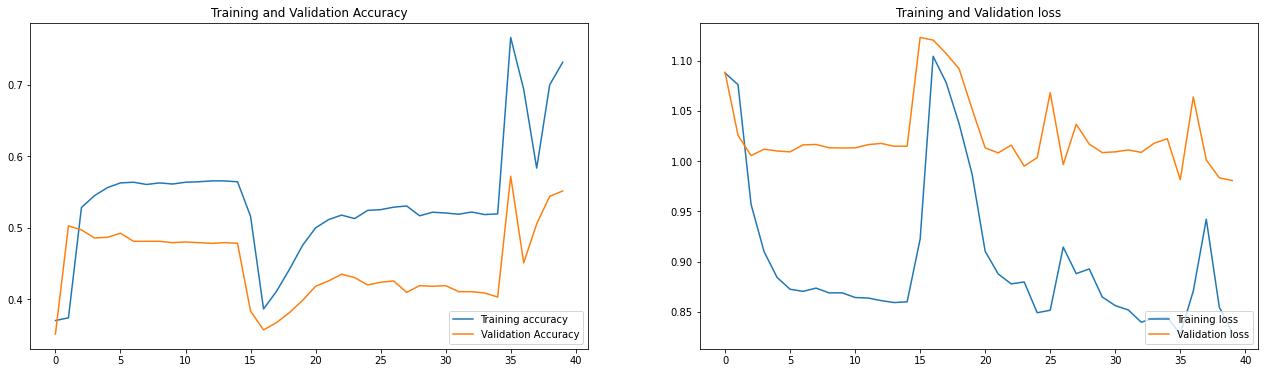

In [27]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(22,6))

plt.subplot( 1,2,1 )
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot( 1,2,2 )
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation loss')

## Test results

In [28]:
# print(model.metrics_names)
results = model.evaluate(X_test_pad, y_test)
print(results)
perdictions = model.predict(X_test_pad)

perdictions = np.argmax(perdictions, axis=1)
# print(perdictions)

34/34 [==============================] - 0s 10ms/step - loss: 0.9945 - accuracy: 0.5361
[0.99445641040802, 0.5360824465751648]


# Model - Word2vec embedding

## Train word2vec

In [33]:
from gensim.models import Word2Vec, FastText

print('Total training sentences: %d' % len(vocab))
# train word2vec model
model = Word2Vec(vocab, size=EMBEDDING_DIM, window=5, min_count=1, workers=4)
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))

filename = "embeddings_word2vec.txt"
model.wv.save_word2vec_format( filename, binary=False )

Total training sentences: 8531
Vocabulary size: 17629


## load word2vec vetor file

In [34]:
# # print(model.wv.similarity('কেউ', 'মিষ্টি'))
# print(model.wv.most_similar("কেউ"))
# # print(model.wv.most_similar(positive='মিষ্টি', topn=15))

embedding_index = {}
f = open(filename, encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embedding_index[word] = coefs
f.close() 

## Tokenize & Embedding layer

In [35]:
# vectorize the text sample into 2D integer tenosr
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(X)
sequences = tokenizer_obj.texts_to_sequences(X)


# pad sequences 
word_index = tokenizer_obj.word_index
print( "Found %s unique tokens." % len(word_index) )

lines_pad = pad_sequences(sequences, maxlen= max_length)
sentiment = y.values
print('shape of the lines tensors', lines_pad.shape)
print('shape of the sentiment tensors', sentiment.shape)


num_words = len(word_index)+1
embedding_matrix = np.zeros( (num_words, EMBEDDING_DIM) )

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        #words not found in embedding index will be all-zeros
        embedding_matrix[i] = embedding_vector
print(num_words)

Found 17856 unique tokens.
shape of the lines tensors (8531, 32)
shape of the sentiment tensors (8531,)
17857


In [36]:
embedding_layer = Embedding(num_words, 
                            EMBEDDING_DIM,
                            embeddings_initializer= Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False
                            )

## Model architecture

### GRU

In [13]:
model = Sequential()
model.add(embedding_layer)
model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer= 'adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 100)           1785700   
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                12864     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 1,798,663
Trainable params: 12,963
Non-trainable params: 1,785,700
_________________________________________________________________


### LSTM

In [37]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer= 'adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 32, 100)           1785700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                7488      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 51        
Total params: 1,793,239
Trainable params: 7,539
Non-trainable params: 1,785,700
_________________________________________________________________


##Train

In [38]:
epochs = 40
batch_size = 64
history = model.fit(
                X_train_pad, y_train,
                validation_data = (X_val_pad, y_val),
                epochs = epochs,
                batch_size=batch_size,
                verbose=2
                )

Epoch 1/40
100/100 - 11s - loss: 1.0905 - accuracy: 0.3787 - val_loss: 1.0949 - val_accuracy: 0.3518
Epoch 2/40
100/100 - 11s - loss: 1.0848 - accuracy: 0.3782 - val_loss: 1.0868 - val_accuracy: 0.3443
Epoch 3/40
100/100 - 11s - loss: 1.0827 - accuracy: 0.3779 - val_loss: 1.0845 - val_accuracy: 0.3996
Epoch 4/40
100/100 - 11s - loss: 1.0812 - accuracy: 0.3876 - val_loss: 1.0827 - val_accuracy: 0.3912
Epoch 5/40
100/100 - 10s - loss: 1.0814 - accuracy: 0.3876 - val_loss: 1.0832 - val_accuracy: 0.4024
Epoch 6/40
100/100 - 11s - loss: 1.0803 - accuracy: 0.3884 - val_loss: 1.0833 - val_accuracy: 0.3921
Epoch 7/40
100/100 - 10s - loss: 1.0797 - accuracy: 0.3876 - val_loss: 1.0813 - val_accuracy: 0.4109
Epoch 8/40
100/100 - 10s - loss: 1.0795 - accuracy: 0.3945 - val_loss: 1.0807 - val_accuracy: 0.4109
Epoch 9/40
100/100 - 11s - loss: 1.0791 - accuracy: 0.3957 - val_loss: 1.0790 - val_accuracy: 0.4231
Epoch 10/40
100/100 - 11s - loss: 1.0780 - accuracy: 0.3951 - val_loss: 1.0774 - val_accura

## Plot traing results

Text(0.5, 1.0, 'Training and Validation loss')

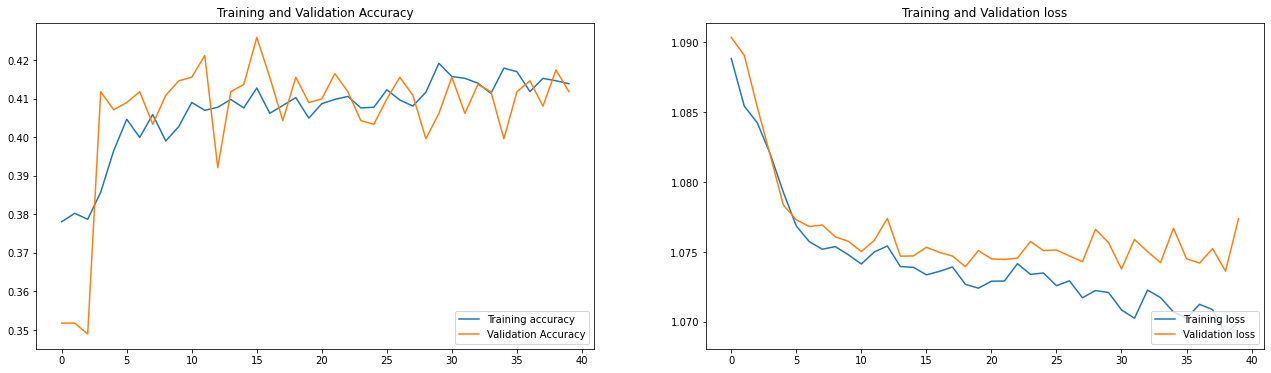

In [15]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(22,6))

plt.subplot( 1,2,1 )
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot( 1,2,2 )
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation loss')

## Test results

In [39]:
# print(model.metrics_names)
results = model.evaluate(X_test_pad, y_test)
print(results)
perdictions = model.predict(X_test_pad)

perdictions = np.argmax(perdictions, axis=1)
# print(perdictions)

34/34 [==============================] - 0s 10ms/step - loss: 1.0552 - accuracy: 0.4630
[1.0552082061767578, 0.46298032999038696]


#Using Fasttext trained vectors from 
    https://fasttext.cc/docs/en/crawl-vectors.html

    @inproceedings{grave2018learning,
        title={Learning Word Vectors for 157 Languages},
        author={Grave, Edouard and Bojanowski, Piotr and Gupta, Prakhar and Joulin, Armand and Mikolov, Tomas},
        booktitle={Proceedings of the International Conference on Language Resources and Evaluation (LREC 2018)},
        year={2018}
        }

##Install fasttext

In [ ]:
%pip install fasttext

     |████████████████████████████████| 71kB 4.1MB/s 


In [ ]:
import fasttext
import fasttext.util

## Download fasttext model

In [ ]:
# # fasttext.util.download_model('bn', if_exists='ignore')  # Bengali
# # ft = fasttext.load_model('cc.bn.300.bin')
# ft = fasttext.load_model('/content/drive/MyDrive/Work_FTFL_GIGATECH/Sentiment analysis project/cc.bn.300.bin')



# ft.get_dimension()
# print(ft.get_dimension(), type(ft), len(ft.words) )
# fasttext.util.reduce_model(ft, 100)
# print(ft.get_dimension(), type(ft), len(ft.words) )
# # print(ft.get_word_vector('আরাম'))
# ft.get_nearest_neighbors('আপনাদেদ')
# # ft.similarity('কেউ', 'মিষ্টি')

## train val test split & Tokenization

In [ ]:
## train test split
X = excel_data["Text"]
y = excel_data["Polarity "]
TRAIN, val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.25,
                                                        shuffle = True ,random_state=random_state)
val, test, y_val, y_test = train_test_split(val_test, y_val_test, test_size=0.5,
                                            shuffle = True, random_state=random_state)

# TRAIN = TRAIN.to_numpy()
val = val.to_numpy()
test = test.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

print(TRAIN.shape)
print(y_train.shape)
print(val.shape)
print(y_val.shape)
print(test.shape)
print(y_test.shape)


# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(X)

# max_length = max([len(excel_data.at[index, 'Text'].split()) for index in excel_data.index])
max_length = max([len(s.split()) for s in X])
print("maximam words in a text: ", max_length)

# sequence encode
X_train_encoded = tokenizer.texts_to_sequences(TRAIN)
X_train = pad_sequences(X_train_encoded, maxlen=max_length, padding='post')

X_val_encoded = tokenizer.texts_to_sequences(val)
X_val = pad_sequences(X_val_encoded, maxlen=max_length, padding='post')

X_test_encoded = tokenizer.texts_to_sequences(test)
X_test = pad_sequences(X_test_encoded, maxlen=max_length, padding='post')

# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

## Load Fasttext Embedding

In [ ]:
# load embedding as a dict# load embedding as a dict
def load_embedding(filename):
	# load embedding into memory, skip first line
	file = open(filename,'r')
	lines = file.readlines()[1:]
	file.close()
	# create a map of words to vectors
	embedding = dict()
	for line in lines:
		parts = line.split()
		# key is string word, value is numpy array for vector
		embedding[parts[0]] = np.asarray(parts[1:], dtype='float16')
	return embedding

raw_embedding = dict()
vec_filename = ['/content/drive/MyDrive/Work_FTFL_GIGATECH/Sentiment analysis project/cc.bn.300.vec',
                '/content/embedding_word2vec.txt'
				]
# load embedding from file
for vec_file in vec_filename:
	temp = load_embedding(vec_file)
	raw_embedding.update(temp)
	print(len(raw_embedding), type(raw_embedding))

In [ ]:
# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
	# total vocabulary size plus 0 for unknown words
	vocab_size = len(vocab) + 1
	# define weight matrix dimensions with all 0
	weight_matrix = np.zeros((vocab_size, 300))
	# step vocab, store vectors using the Tokenizer's integer mapping
	for word, i in vocab.items():
		weight_matrix[i] = embedding.get(word)
	return weight_matrix

# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
print(embedding_vectors[0:2])
# create the embedding layer
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_vectors], input_length=max_length, trainable=False)

## Model architecture

In [ ]:
opt = optimizers.Adam(learning_rate=0.0001)

In [ ]:
# define model
model = Sequential()
model.add(embedding_layer)
model.add( LSTM(32, input_shape=(32,1), return_sequences=True) )
# model.add(Dropout(0.2))
model.add( LSTM(16, input_shape=(32,1)) )
# model.add(Dropout(0.2))
model.add(Dense(3, activation='sigmoid'))

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer= opt,
              metrics=['accuracy'])
model.summary()

In [ ]:
l = [X_train, X_val, X_test, y_train, y_val, y_test]
for i in range(0, len(l)):
    print(type(l[i][0]))
    print(l[i].shape)

In [ ]:
epochs = 1000
batch_size = 32
history = model.fit(
                X_train, y_train,
                validation_data = (X_val, y_val),
                epochs = epochs,
                batch_size=batch_size
                )

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(22,6))

plt.subplot( 1,2,1 )
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot( 1,2,2 )
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation loss')